# **How the Top Ladder has evolved since the S2 - Hearthstone Battlegrounds ?**

## **Introduction**

This Jupyter notebook aims to trace the history of each Hearthstone Battlegrounds season by analyzing players who have achieved a rating of at least **8000 MMR**.

> By fetching these leaderboards via the Blizzard API and displaying them side by side, we will be able to:
>
> * Compare the distribution of top‑tier players across seasons
> * Track the number of participants crossing the **8000 MMR** threshold
> * Analyze regional dominance within the top ladder
> * Highlight additional dynamics and evolutions of the ladder
>

This holistic approach will provide a clear view of how the top ladder has evolved since Season 2, identifying key trends and standout moments from each period.


## **Part 1: Data Concatenation**

### **Objective**

In this section, we will implement reusable functions to load, clean and merge our leaderboard data into a single consolidated dataset. By the end of this step, all regional files from each season will be concatenated in a uniform format, ready for downstream analysis.

### **Directory Structure**
 
Our raw data are organized under a top‑level `data/` folder, with one subfolder per season (`s3`, `s8`, `s9`, ...), and within each season folder, one subfolder per region (`EU`, `NA`, `AP`):

> ```text
> data/
> ├── s2/
> │   ├── EU/
> │   ├── NA/
> │   └── AP/
> .
> .
> .
> ├── s8/
> │   ├── EU/
> │   ├── NA/
> │   └── AP/
> └── s9/
>     ├── EU/
>     ├── NA/
>     └── AP/
> ```

We will walk through the creation of functions that traverse this structure, read each file, and concatenate them into a master DataFrame.

At the end we want to keep the informations related to the region and the season of each player. We will add two columns related to the name of the folder in our final dataframe. We will aslo filter the data by keeping the player that are above 8000 MMR (during the s3 all the players have been included in the leaderboard)


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D

In [46]:
def load_all_seasons_filtered(data_root: str, min_rating: int = 8000) -> pd.DataFrame:
    """
    Loads and concatenates Battlegrounds data for all seasons, filtering out players below a minimum rating
    and skipping any 'pa' (AP) region directories.
    
    Parameters
    ----------
    data_root : str
        Path to the root 'data/' directory containing season subfolders (e.g., 's3', 's8', 's9', ...).
    min_rating : int, optional
        Minimum MMR rating to include (default is 8000).
    
    Returns
    -------
    pd.DataFrame
        A concatenated DataFrame with columns: 'rank', 'accountid', 'rating', 'season', 'region'.
    """
    root = Path(data_root)
    all_dfs = []

    for season_dir in root.glob("s*"):
        season = season_dir.name  # e.g. "s3", "s8", "s9"
        for region_dir in season_dir.iterdir():
            # Skip non-directories and any folder named 'ap'
            if not region_dir.is_dir() or region_dir.name.lower() == "ap":
                continue

            region = region_dir.name.lower()  # e.g. "eu", "na", "ap"
            csv_path = region_dir / "battlegrounds.csv"
            if csv_path.exists():
                df = pd.read_csv(csv_path)
                df = df[df["rating"] >= min_rating]
                df["season"] = season
                df["region"] = region
                all_dfs.append(df)

    # Concatenate all DataFrames into one
    return pd.concat(all_dfs, ignore_index=True)

In [47]:
df_top = load_all_seasons_filtered("data", min_rating=8000)
df_top.head()

,rank,accountid,rating,season,region
0,1,LOUDER,17527,s3,eu
1,2,huyagaoshou,17245,s3,eu
2,3,Sevel,16688,s3,eu
3,4,douyumxjf,16054,s3,eu
4,5,wtybill,16034,s3,eu


## **Part 2: Evolution of the Number of Players on the Top Leaderboard**

### **Total Number of Players**

We can now display the number of players who have reached 8000 MMR across all regions. This allows us to observe the differences in the player base from one season to the next.

In [48]:
def plot_player_counts_by_season_vertical(df):
    """
    Plots a vertical bar chart of the number of players ≥8000 MMR per season.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing at least a 'season' column and filtered for rating ≥8000.
    """
    # Count the number of players per season
    counts = df.groupby('season').size()
    # Sort seasons in chronological order (extract numeric part)
    seasons_ordered = sorted(counts.index, key=lambda s: int(s.lstrip('s')))
    counts = counts.reindex(seasons_ordered, fill_value=0)

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.bar(seasons_ordered, counts.values)
    plt.xlabel("Season")
    plt.ylabel("Number of Players")
    plt.title("Number of Players ≥8000 MMR by Season")
    plt.tight_layout()
    plt.show()

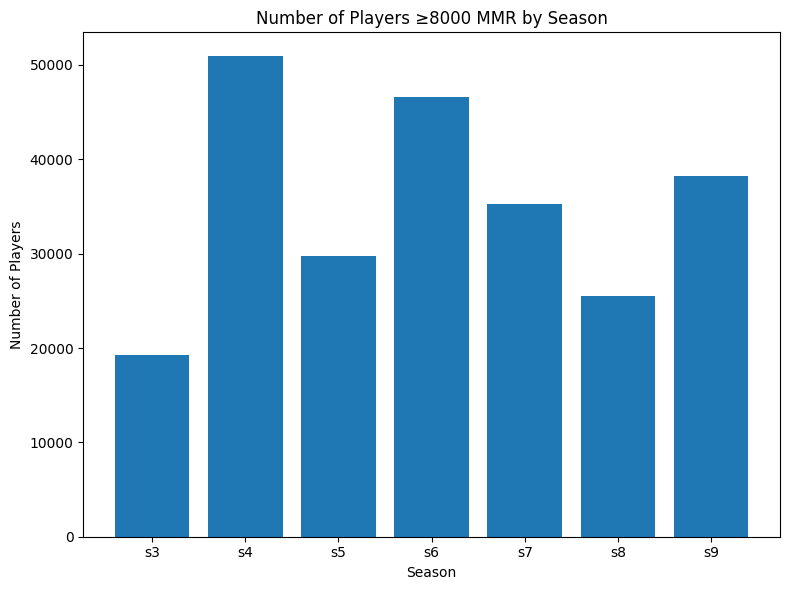

In [49]:
plot_player_counts_by_season_vertical(df_top)

### **Total Number of Players per regions**

The objective now is to separate each region within a single season. This will allow us to determine whether the overall trend visible in the previous chart applies uniformly across regions, or whether anomalies can be observed in certain areas.

> It’s impossible to retrieve the AP region leaderboard because the HSBG API returns the NA data for Seasons 6 and 7.

In [50]:
def plot_player_counts_by_season_by_region_grouped(df):
    """
    Plots a grouped vertical bar chart showing the number of players ≥8000 MMR per season by region.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing at least 'season' and 'region' columns and filtered for rating ≥8000.
    """
    # Pivot counts per season and region
    counts = df.groupby(['season', 'region']).size().unstack(fill_value=0)
    # Sort seasons in chronological order (extract numeric part)
    seasons_ordered = sorted(counts.index, key=lambda s: int(s.lstrip('s')))
    counts = counts.reindex(seasons_ordered)

    regions = ['eu', 'na']
    x = np.arange(len(seasons_ordered))
    width = 0.2  # width of each bar
    offsets = np.linspace(-width, width, len(regions))  # offsets for grouped bars

    plt.figure(figsize=(10, 6))
    for i, region in enumerate(regions):
        values = counts.get(region, np.zeros(len(seasons_ordered))).values
        plt.bar(x + offsets[i], values, width=width, label=region.upper())

    plt.xlabel("Season")
    plt.ylabel("Number of Players")
    plt.title("Number of Players ≥8000 MMR by Season and Region")
    plt.xticks(x, seasons_ordered)
    plt.legend(title="Region")
    plt.tight_layout()
    plt.show()

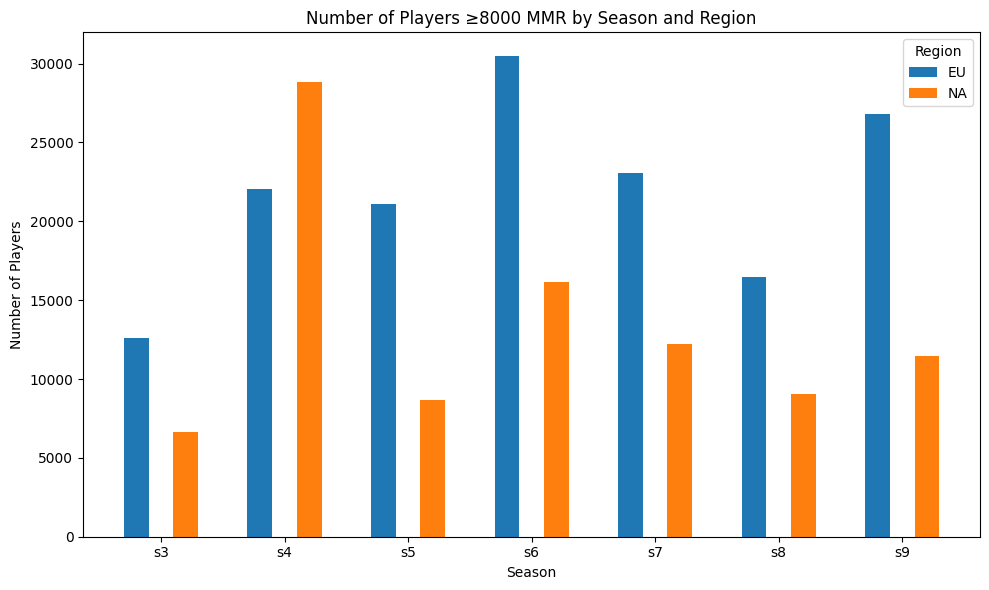

In [51]:
plot_player_counts_by_season_by_region_grouped(df_top)

### **Analysis of player count differences between seasons by region (NA & EU)**

In [52]:
def plot_eu_na_difference_by_season(df):
    """
    Plots a continuous line chart showing the difference (EU - NA) in number of players ≥8000 MMR per season.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing at least 'season' and 'region' columns and filtered for rating ≥8000.
    """
    # Pivot counts per season and region
    counts = df.groupby(['season', 'region']).size().unstack(fill_value=0)
    
    # Sort seasons in chronological order (extract numeric part)
    seasons_ordered = sorted(counts.index, key=lambda s: int(s.lstrip('s')))
    counts = counts.reindex(seasons_ordered)
    
    # Calculate the difference EU - NA for each season
    eu_counts = counts.get('eu', np.zeros(len(seasons_ordered))).values
    na_counts = counts.get('na', np.zeros(len(seasons_ordered))).values
    difference = eu_counts - na_counts
    
    # Create the continuous line plot
    plt.figure(figsize=(12, 6))
    plt.plot(seasons_ordered, difference, marker='o', linewidth=2, markersize=6, color='steelblue')
    
    # Add a horizontal line at y=0 for reference
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1)
    
    # Center the plot around the x-axis (y=0)
    max_abs_diff = max(abs(np.min(difference)), abs(np.max(difference)))
    plt.ylim(-max_abs_diff * 1.1, max_abs_diff * 1.1)
    
    # Formatting
    plt.xlabel("Season")
    plt.ylabel("Difference in Number of Players (EU - NA)")
    plt.title("Difference in Number of Players ≥8000 MMR: EU - NA by Season")
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Add annotations to show positive/negative regions
    plt.text(0.02, 0.95, 'EU > NA', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
    plt.text(0.02, 0.05, 'NA > EU', transform=plt.gca().transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    stats_data = {
        'Statistic': ['Average EU - NA difference', 'Maximum difference (EU favored)', 'Minimum difference (NA favored)'],
        'Value': [np.mean(difference), np.max(difference), np.min(difference)],
        'Season': ['All seasons', seasons_ordered[np.argmax(difference)], seasons_ordered[np.argmin(difference)]]
    }
    
    stats_df = pd.DataFrame(stats_data)
    
    return difference, seasons_ordered, stats_df

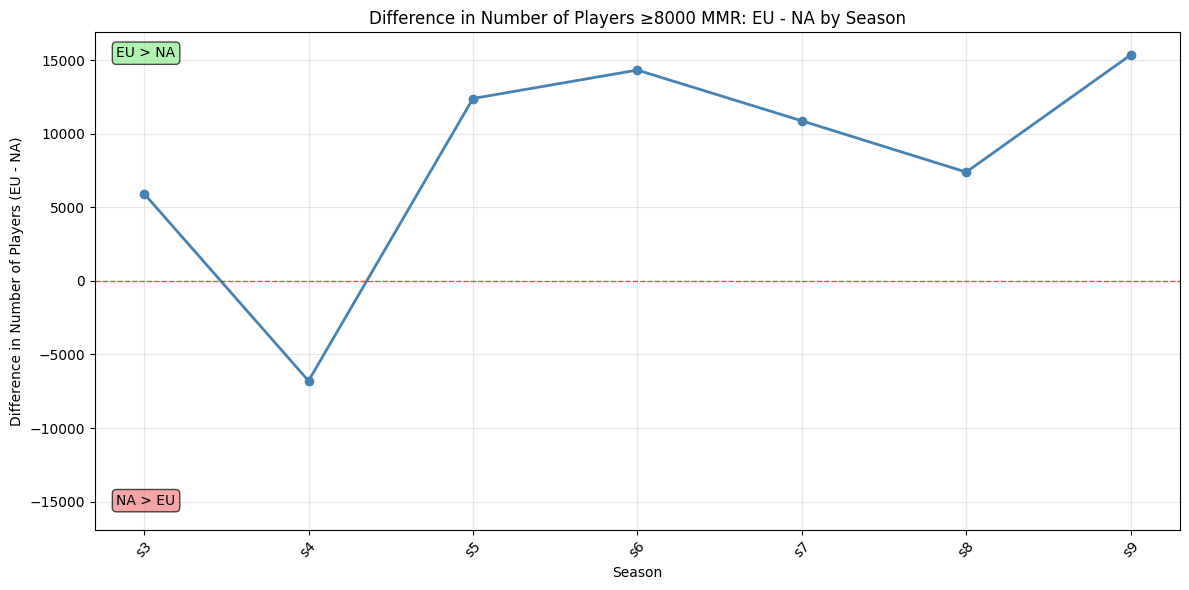

,Statistic,Value,Season
0,Average EU - NA difference,8500.857143,All seasons
1,Maximum difference (EU favored),15360.000000,s9
2,Minimum difference (NA favored),-6792.000000,s4


In [53]:
difference, seasons_ordered, stats_df = plot_eu_na_difference_by_season(df_top)
stats_df.head()

### **Comparison of MMR differences among the top X players in each region**

In [54]:
def plot_topN_mmr_diff_by_region_quad_bars(df, thresholds=[10, 100, 1000, 10000]):
    """
    Plots a 2x2 grid of bar charts showing the difference in average MMR (EU - NA)
    for the top N players per season, with region demarcation text inside each subplot.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing 'season', 'region', 'rank', and 'rating' columns.
    thresholds : list of int, optional
        List of top-N thresholds to plot (default: [10, 100, 1000, 10000]).
    """
    # Chronologically sort seasons
    seasons = sorted(df['season'].unique(), key=lambda s: int(s.lstrip('s')))

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    for ax, top_n in zip(axes.flat, thresholds):
        # Filter to top N players
        df_topN = df[df['rank'] <= top_n]
        # Compute average MMR per season & region
        avg_mmr = (
            df_topN
            .groupby(['season', 'region'])['rating']
            .mean()
            .unstack(fill_value=0)
            .reindex(seasons)
        )

        # Difference EU - NA
        diff = avg_mmr.get('eu', np.zeros(len(seasons))) - avg_mmr.get('na', np.zeros(len(seasons)))

        # Bars
        x = np.arange(len(seasons))
        ax.bar(x, diff, edgecolor='black')

        # Zero line
        ax.axhline(0, color='black', linestyle='--', linewidth=1)

        # Demarcation labels inside subplot
        ax.text(0.02, 0.95, 'EU > NA', transform=ax.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
        ax.text(0.02, 0.05, 'NA > EU', transform=ax.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

        # Axis formatting
        ax.set_xticks(x)
        ax.set_xticklabels(seasons)
        ax.set_title(f"Top {top_n} EU - NA Avg MMR Difference")
        ax.set_xlabel("Season")
        ax.set_ylabel("EU - NA MMR")

    plt.tight_layout()
    plt.show()


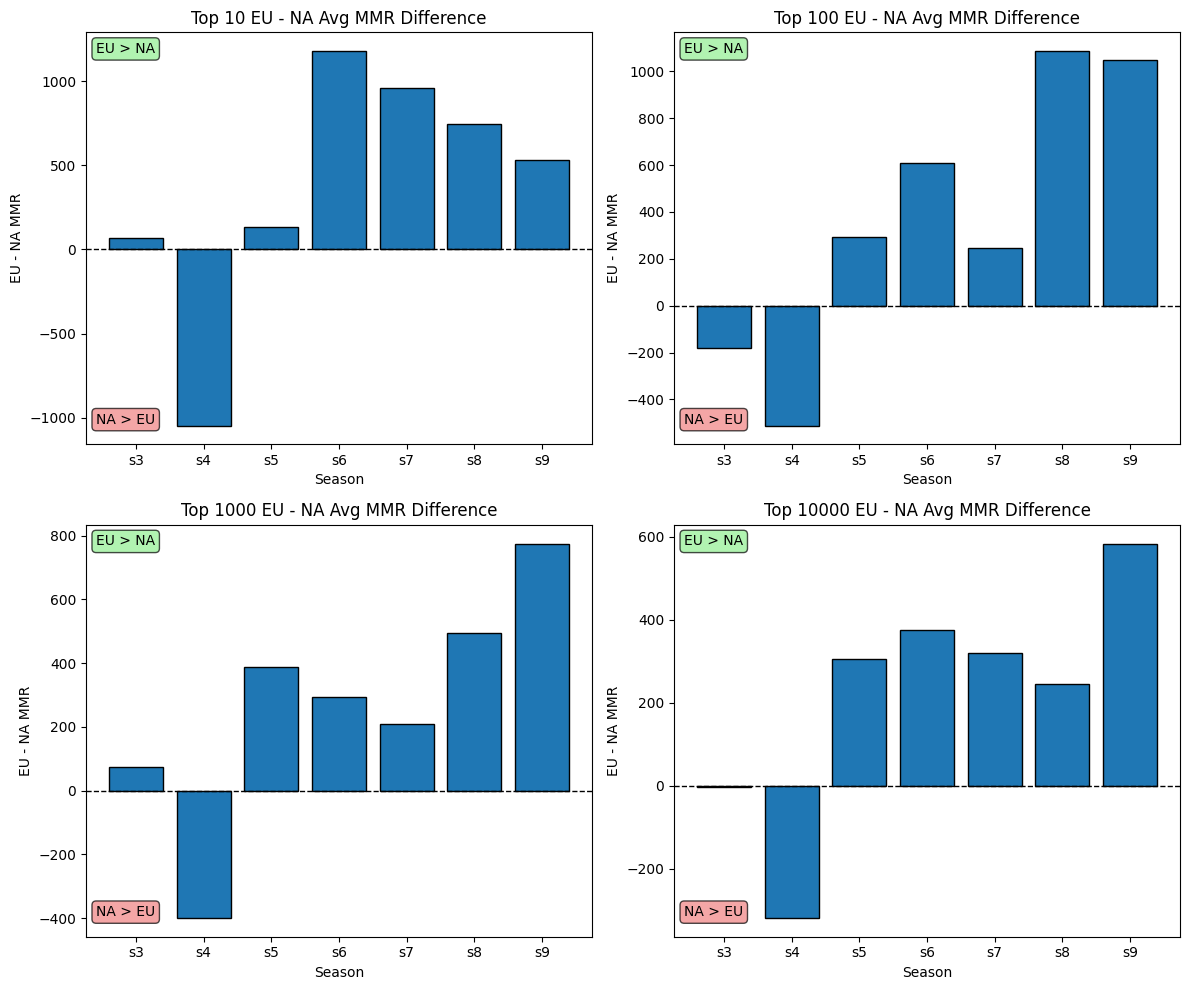

In [55]:
plot_topN_mmr_diff_by_region_quad_bars(df_top)